# Mandelbrot Set
The Mandelbrot set is the set of complex numbers $c$ for which the absolute value of the sequence $z_n$ remains bounded for all $n > 0$, where $z_n$ is:
$$
\begin{align}
z_0 &= 0, \\
z_{n+1} &= z_n^2 + c.
\end{align}
$$
For any complex number $c$, one of two things will happen:
- The sequence blows up to infinity ($|z_n| \gt 2$)
- The sequence if bounded ($|z_n| \le 2$)

Then, $c$ belongs to the Mandelbrot set $M$ if the second case ($|z_n| \le 2$) holds:
$$
M = \{c \in \mathbb{C} \mid \lvert z_n \rvert \le 2 \}.
$$

In [47]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import queue
import shelve
import time
from statistics import NormalDist
import seaborn as sns
import pandas as pd


# plot settings
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 12
mpl.rcParams["font.size"] = 12

TEX_PLOTS = False

if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{palatino}
     \usepackage{newpxmath}""")
    
plt.rc("font", family="serif")

In [48]:
from cpp_stoch import (
    f_c as f_c_cpp,
    mandelbrot_grid,
    set_num_threads,
    get_num_threads
)

from Function import Monte_carlo, I_iter_worker, S_iter_worker, \
  uniform_sampler, latin_square_sampler, orthogonal_sampler, N_iter_worker

In [49]:
# RNG initialization for parallel sampling
#  see https://albertcthomas.github.io/good-practices-random-number-generators/
#  and https://numpy.org/doc/stable/reference/random/bit_generators/mt19937.html#numpy.random.MT19937
from numpy.random import Generator, MT19937, SeedSequence

def initialize_parallel_rngs(n, seed):
    sg = SeedSequence(seed)
    bit_generator = MT19937(sg)
    rngs = []
    for _ in range(n):
        rngs.append(Generator(bit_generator))
        bit_generator = bit_generator.jumped()
        
    return rngs

In [50]:
from scipy import stats

def Confidence_intervals(Samples, p = 0.95):
    Lambda = NormalDist().inv_cdf((p + 1)/2)
    S = np.std(Samples, ddof = 1)
    a = (Lambda*S)/np.sqrt(len(Samples))
    return a

def sp_confidence_interval(samples, p=0.95):
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

In [51]:
def S_iter(max_iter, n_runs, S_min_exp, S_max_exp, sampling_method = uniform_sampler, steps = 4):
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    sample_size_range = np.logspace(S_min_exp, S_max_exp, num = ((S_max_exp - S_min_exp) + 1)*steps, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for sample_size in sample_size_range:
            work_queue.put((sample_size, i))


    rngs = initialize_parallel_rngs(mp.cpu_count(), 273583)
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=S_iter_worker, args=(
            work_queue, Approx_areas_list, max_iter, rngs[i], sampling_method
        ))
        p.daemon = True
        p.start()
        processes.append(p)


    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], sample_size_range        

In [52]:
def I_iter(sample_size, n_runs, I_min_exp, I_max_exp, sampling_method = uniform_sampler, steps = 4):
    manager = mp.Manager()

    Approx_areas_list = manager.list()  
    iteration_range = np.logspace(I_min_exp, I_max_exp, num = ((I_max_exp - I_min_exp) + 1)*steps, dtype = int)

    work_queue = mp.Queue()
    for i in range(n_runs):
        Approx_areas_list.append(manager.list())
        for max_iter in iteration_range:
            work_queue.put((max_iter, i))

    rngs = initialize_parallel_rngs(mp.cpu_count(), 879142)
    processes = []
    for i in range(mp.cpu_count()):
        p = mp.Process(target=I_iter_worker, args=(
            work_queue, Approx_areas_list, sample_size, rngs[i], sampling_method 
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return [list(v) for v in Approx_areas_list], iteration_range

In [53]:
def Plotter_S(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    # a = np.array([Confidence_intervals(samples) for samples in Approx_areas_list_array.T])
    a_scipy = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]

    Error = np.abs(Area_means - Area_means[-1])

    #conf_lower = Area_means - a
    #conf_upper = Area_means + a
    
    fig,ax = plt.subplots(figsize=(5.25, 4))
    
    plt.grid(alpha=0.5)
    
    ax.plot(sample_size_range, Area_means, color = "tab:blue")
    # ax.fill_between(sample_size_range, conf_lower, conf_upper, color='tab:red', alpha=0.1)
    ax.fill_between(sample_size_range, Area_means - a_scipy, Area_means + a_scipy, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(sample_size_range, Error, color = "black", linestyle='dashed')
    ax2.set_ylim(-0.05, 0.65)
    
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.6)
    ax.yaxis.label.set_color('tab:blue')

    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{i,s}$")
        ax.set_xlabel("Number of samples ($s$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{i, s_n} - A_{i, s_j}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_s.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of samples (s)")
        ax2.set_ylabel("Difference mean area (|A_j - A_i|)")
    
    plt.show()

In [54]:
def Plotter_I(Approx_areas_list, iteration_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    # Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    a_scipy = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]
    Error = np.abs(Area_means - Area_means[-1])


    #std_lower = Area_means - Area_std
    #std_upper = Area_means + Area_std
    
    fig,ax = plt.subplots(figsize=(5.25, 4))
    
    plt.grid(alpha=0.5)
    
    ax.plot(iteration_range, Area_means, color = "tab:blue")
    ax.fill_between(iteration_range, Area_means - a_scipy, Area_means + a_scipy, color='tab:blue', alpha=0.1)

    ax2=ax.twinx()
    ax2.plot(iteration_range, Error, color = "black", linestyle='dashed')
            
    ax.set_xscale('log')
    ax.set_ylim(0.5, 2.6)
    ax.yaxis.label.set_color('tab:blue')
    ax2.set_ylim(-0.05, 0.65)
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{i,s}$")
        ax.set_xlabel("Number of iterations ($i$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{i_n, s} - A_{i_j, s}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_i.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of iteration (i)")
        ax2.set_ylabel("Difference mean area (A_js - A_is)")

    plt.show()

In [55]:
def N_iter(S_fix, I_fix, sampling_method):
    manager = mp.Manager()

    Approx_areas_list = manager.dict()  
    runs_size_range = np.linspace(10,1000, 10, dtype = int)
    work_queue = mp.Queue()
    
    for runs_size in runs_size_range:
        Approx_areas_list[runs_size] = manager.list()
        
        for i in range(runs_size):
            work_queue.put((runs_size, i))

        rngs = initialize_parallel_rngs(mp.cpu_count(), 273583)
        processes = []
        for i in range(mp.cpu_count()):
            p = mp.Process(target=N_iter_worker, args=(
                work_queue, Approx_areas_list, S_fix, I_fix, rngs[i], sampling_method
            ))
            p.daemon = True
            p.start()
            processes.append(p)


        for p in processes:
            p.join()

    return {k: list(v) for k, v in Approx_areas_list.copy().items()}, runs_size_range    



def Plotter_N(Dic_PRS, Dic_LHS, Dic_OS):
    Sampling_methods = [Dic_PRS, Dic_LHS, Dic_OS]
    fig,ax = plt.subplots(figsize=(5.25, 4))
    ax2=ax.twinx()
    run_size_range = list(Dic_PRS.keys())
    
    for Sampling_method in Sampling_methods:
        Approx_areas_list = list(Sampling_method.values())
        
        Area_means = []
        a_scipy = []
        
        for row in Approx_areas_list:
            mean = sum(row)/len(row)
            a = sp_confidence_interval(row)
            Area_means.append(mean)
            a_scipy.append(a)  
        
        Area_means = np.array(Area_means)
        a_scipy = np.array(a_scipy)
        
        Error = np.abs(Area_means - Area_means[-1])
        
        ax2.plot(run_size_range, Error, linestyle='dashed')
        ax.fill_between(run_size_range, Area_means - a_scipy, Area_means + a_scipy, alpha=0.1)
        ax.plot(run_size_range, Area_means)
        
    
    
    plt.legend(["PRS", "LHS", "OS"])
    plt.grid(alpha=0.5)    
    ax.set_ylim(1.495, 1.517)
    ax.yaxis.label.set_color('tab:blue')
    ax2.set_ylim(0, 0.005)
    
    if TEX_PLOTS:
        ax.set_ylabel("Mean approximated area $A_{i,s}$")
        ax.set_xlabel("Number of runs ($r$)")
        ax2.set_ylabel("Difference mean area $\\left\\lvert A_{i_n, s} - A_{i_j, s}\\right\\rvert$")
        plt.savefig('figures/convergence_varying_i.pdf', bbox_inches='tight')
    else:
        ax.set_ylabel("Mean approximated area A_is")
        ax.set_xlabel("Number of runs (r)")
        ax2.set_ylabel("Difference mean area (A_js - A_is)")

    plt.show()

In [56]:
def Statistics_print(Approx_areas_list, sample_size_range):
    Approx_areas_list_array = np.array(Approx_areas_list)
    Area_means = np.mean(Approx_areas_list_array, axis = 0)
    Area_std = np.std(Approx_areas_list_array, axis = 0, ddof = 1)
    a = [sp_confidence_interval(samples) for samples in Approx_areas_list_array.T]
    a2 = np.array([Confidence_intervals(samples) for samples in Approx_areas_list_array.T])
    Error = np.abs(Area_means- Area_means[-1])
    print("Means: ", Area_means)
    print("Error: ", Error)
    print("Confidence radius scipy: ", a)
    print("Confidence radius old: ", a2)

    print("Std: ", Area_std)

### Uniform results ###

In [57]:
%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/S_iter")
#Approx_areas_list_S_Uni, sample_size_range_S_Uni = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 1, S_max_exp = 7)
#Approx_areas_list_S_Uni, sample_size_range_S_Uni = S_iter(max_iter = int(1e1), n_runs = 1, S_min_exp = 1, S_max_exp = 2)
#shelf["Approx_areas_list_S_Uni"] = Approx_areas_list_S_Uni
#shelf["sample_size_range_S_Uni"] = sample_size_range_S_Uni
#shelf.close()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


In [58]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/S_iter")
Approx_areas_list_S_Uni = shelf["Approx_areas_list_S_Uni"]
sample_size_range_S_Uni = shelf["sample_size_range_S_Uni"]
shelf.close()

In [59]:
Statistics_print(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

Means:  [1.57248    1.5708     1.40871111 1.56605217 1.50632727 1.50965581
 1.53028465 1.50572925 1.51587045 1.4771904  1.50644029 1.51149274
 1.51011041 1.5019226  1.50865171 1.50732744 1.50665399 1.50648706
 1.50715488 1.50604945 1.50591226 1.50735942 1.50713031 1.5068015
 1.50745256 1.50698168 1.5069446  1.50683801]
Error:  [6.56419949e-02 6.39619949e-02 9.81268940e-02 5.92141688e-02
 5.10732393e-04 2.81780883e-03 2.34466460e-02 1.10875721e-03
 9.03244563e-03 2.96476051e-02 3.97717350e-04 4.65473392e-03
 3.27240212e-03 4.91540114e-03 1.81370220e-03 4.89436395e-04
 1.84012132e-04 3.50942999e-04 3.16874880e-04 7.88554847e-04
 9.25744783e-04 5.21416456e-04 2.92300732e-04 3.65070739e-05
 6.14556806e-04 1.43675674e-04 1.06594521e-04 0.00000000e+00]
Confidence radius scipy:  [0.6202765531114283, 0.3822345220115273, 0.2978561948286562, 0.24714256686167113, 0.17950176273591634, 0.13030447056741945, 0.10761361442893103, 0.07877799452424661, 0.06620080503955439, 0.046214942314653396, 0.039239

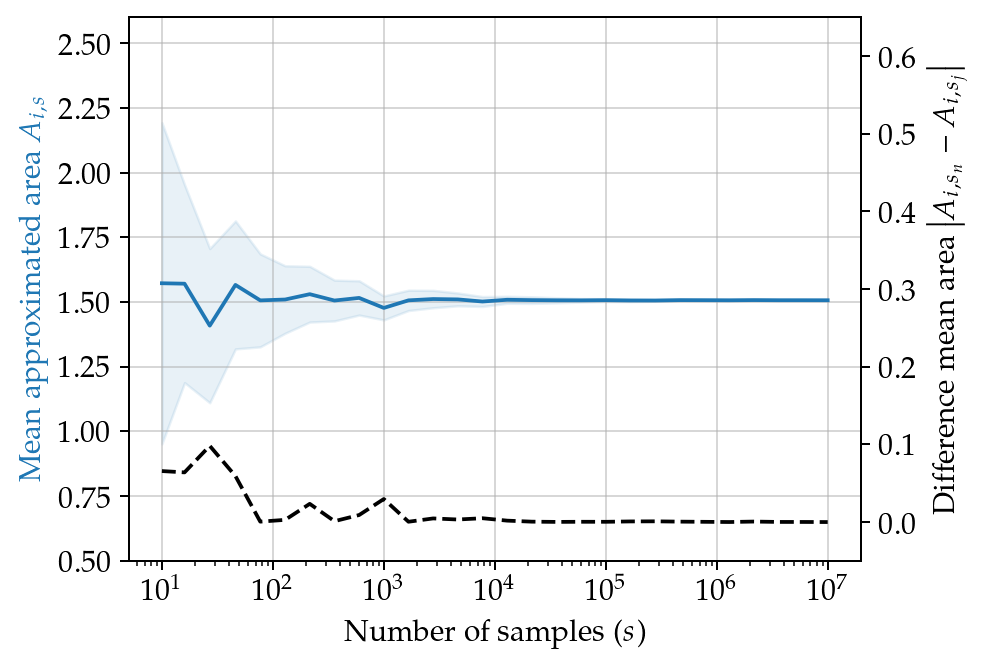

In [60]:
Plotter_S(Approx_areas_list_S_Uni, sample_size_range_S_Uni)

In [61]:
%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/I_iter")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 1, I_max_exp = 7)
#shelf["Approx_areas_list_I_Uni"] = Approx_areas_list_I_Uni
#shelf["iteration_range_I_Uni"] = iteration_range_I_Uni
#shelf.close()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 6.91 µs


In [62]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_Uni = shelf["Approx_areas_list_I_Uni"]
iteration_range_I_Uni = shelf["iteration_range_I_Uni"]
shelf.close()

In [63]:
Approx_areas_list_array_I_Uni = np.array(Approx_areas_list_I_Uni)
Area_means_I_Uni = np.mean(Approx_areas_list_array_I_Uni, axis = 0)
Area_std_I_Uni = np.std(Approx_areas_list_array_I_Uni, axis = 0)
Error_I_Uni = np.abs(Area_means_I_Uni - Area_means_I_Uni[-1])

In [64]:
print("Means: ", Area_means_I_Uni)
print("Error: ", Error_I_Uni)
print("Std: ", Area_std_I_Uni)

Means:  [2.0984544  1.82099904 1.67067264 1.5977472  1.5547392  1.54363776
 1.52428416 1.51781952 1.51655616 1.50800832 1.50310272 1.50636864
 1.5101184  1.50765888 1.50525312 1.50384192 1.51087104 1.51201344
 1.50687936 1.50416448 1.5018528  1.50429888 1.50868032 1.50841152
 1.50691968 1.51208064 1.5101856  1.51210752]
Error:  [5.8634688e-01 3.0889152e-01 1.5856512e-01 8.5639680e-02 4.2631680e-02
 3.1530240e-02 1.2176640e-02 5.7120000e-03 4.4486400e-03 4.0992000e-03
 9.0048000e-03 5.7388800e-03 1.9891200e-03 4.4486400e-03 6.8544000e-03
 8.2656000e-03 1.2364800e-03 9.4080000e-05 5.2281600e-03 7.9430400e-03
 1.0254720e-02 7.8086400e-03 3.4272000e-03 3.6960000e-03 5.1878400e-03
 2.6880000e-05 1.9219200e-03 0.0000000e+00]
Std:  [0.0270332  0.02719822 0.02764221 0.02918337 0.0281365  0.02968836
 0.02808222 0.03420437 0.03319008 0.03426657 0.02804087 0.02708582
 0.02796812 0.02635653 0.02503088 0.03310117 0.02535229 0.02942086
 0.02534746 0.02652676 0.02538746 0.02734741 0.03010992 0.029854

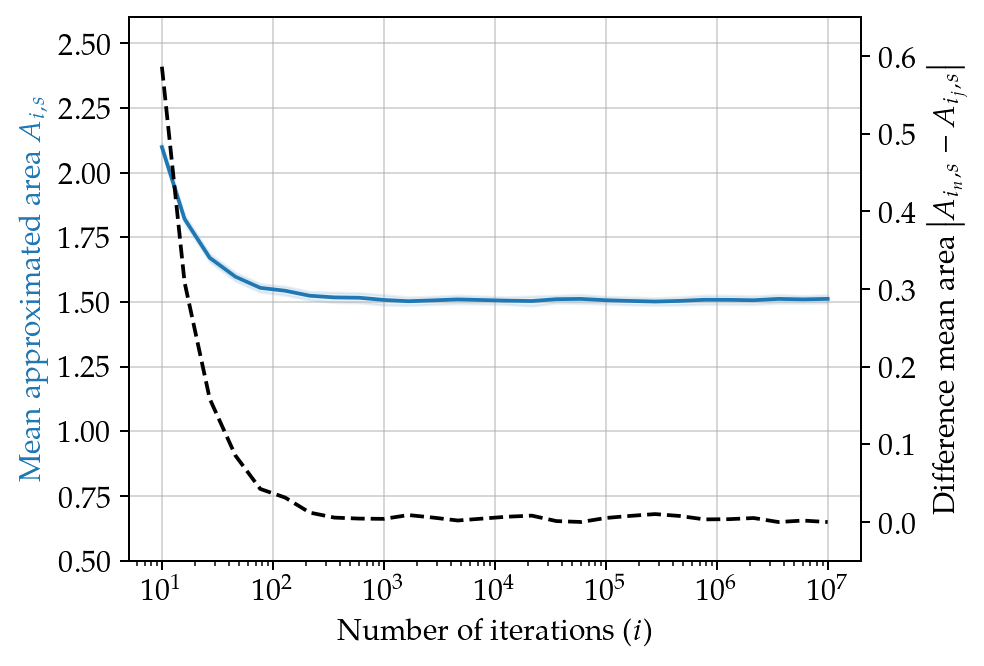

In [65]:
Plotter_I(Approx_areas_list_I_Uni, iteration_range_I_Uni)

### LHS Results ###

In [66]:
%%time
#shelf = shelve.open("Final_arrays_simulations/S_iter")
#Approx_areas_list_S_LHS, sample_size_range_S_LHS = S_iter(max_iter = int(1e4), n_runs = 50, S_min_exp = 1, S_max_exp = 7, sampling_method = latin_square_sampler)
#shelf["Approx_areas_list_S_LHS"] = Approx_areas_list_S_LHS
#shelf["sample_size_range_S_LHS"] = sample_size_range_S_LHS
#shelf.close()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [67]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/S_iter")
Approx_areas_list_S_LHS = shelf["Approx_areas_list_S_LHS"]
sample_size_range_S_LHS = shelf["sample_size_range_S_LHS"]
shelf.close()

In [68]:
Statistics_print(Approx_areas_list_S_LHS, sample_size_range_S_LHS)

Means:  [1.66656    1.3608     1.50826667 1.45502609 1.53949091 1.50340465
 1.5284093  1.49786741 1.51564608 1.5098496  1.50934101 1.50985018
 1.50588235 1.50916166 1.50537366 1.50745845 1.50830323 1.5046666
 1.50696269 1.50653449 1.50681066 1.50659963 1.50665711 1.50661117
 1.50692686 1.50684163 1.50687295 1.50692137]
Error:  [1.59638627e-01 1.46121373e-01 1.34529323e-03 5.18952865e-02
 3.25695357e-02 3.51672228e-03 2.14879289e-02 9.05396397e-03
 8.72470335e-03 2.92822656e-03 2.41963375e-03 2.92880629e-03
 1.03902050e-03 2.24029021e-03 1.54771490e-03 5.37074388e-04
 1.38185991e-03 2.25476905e-03 4.13145600e-05 3.86887498e-04
 1.10714153e-04 3.21748312e-04 2.64258739e-04 3.10203132e-04
 5.48716469e-06 7.97466776e-05 4.84257960e-05 0.00000000e+00]
Confidence radius scipy:  [0.32040857101679654, 0.27940005530396306, 0.22937621377948192, 0.1837366912048548, 0.10594682971700253, 0.09209352981061736, 0.061881091582378644, 0.05837395428686021, 0.045479036736600253, 0.03297905441361593, 0.022

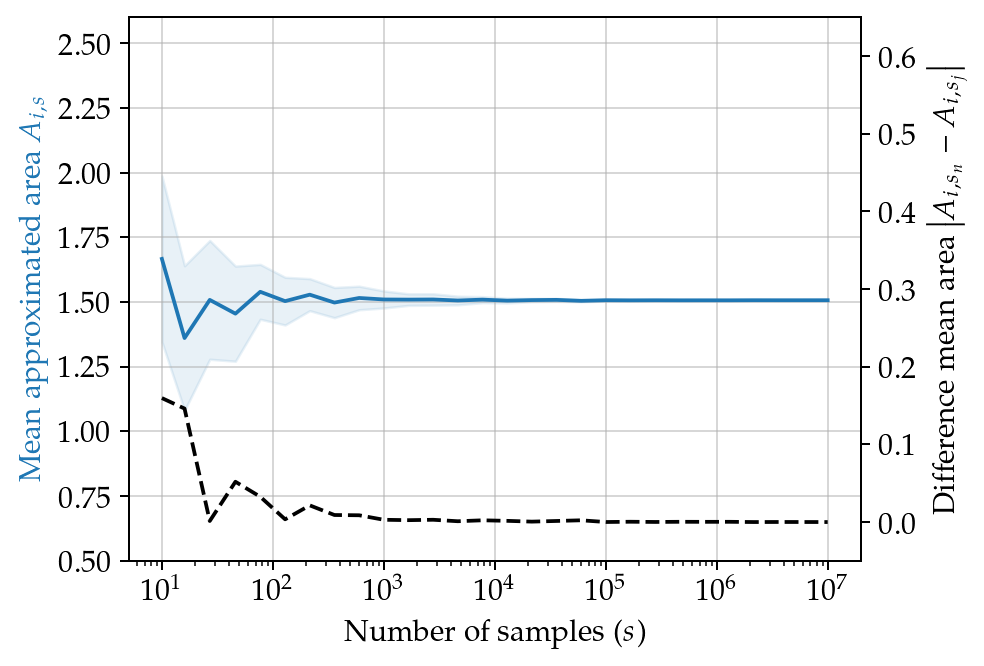

In [69]:
Plotter_S(Approx_areas_list_S_LHS, sample_size_range_S_LHS)

In [70]:
%%time
# Generate and save objects
#shelf = shelve.open("Final_arrays_simulations/I_iter")
#Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e4), n_runs = 50, I_min_exp = 1, I_max_exp = 7, sampling_method = latin_square_sampler)
#shelf["Approx_areas_list_I_LHS"] = Approx_areas_list_I_LHS
#shelf["iteration_range_I_LHS"] = iteration_range_I_LHS
#shelf.close()

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.34 µs


In [71]:
# Open objects to work with 
shelf = shelve.open("Final_arrays_simulations/I_iter")
Approx_areas_list_I_LHS = shelf["Approx_areas_list_I_LHS"]
iteration_range_I_LHS = shelf["iteration_range_I_LHS"]
shelf.close()

In [72]:
Statistics_print(Approx_areas_list_I_LHS, iteration_range_I_LHS)

Means:  [2.09985216 1.82087808 1.67094144 1.5998304  1.55801856 1.53257664
 1.52654208 1.51701312 1.51096512 1.5117312  1.50921792 1.51069632
 1.50330432 1.51225536 1.50464832 1.50416448 1.50264576 1.50900288
 1.5038016  1.50585792 1.50768576 1.50538752 1.51041408 1.50214848
 1.50795456 1.50463488 1.507632   1.51040064]
Error:  [5.8945152e-01 3.1047744e-01 1.6054080e-01 8.9429760e-02 4.7617920e-02
 2.2176000e-02 1.6141440e-02 6.6124800e-03 5.6448000e-04 1.3305600e-03
 1.1827200e-03 2.9568000e-04 7.0963200e-03 1.8547200e-03 5.7523200e-03
 6.2361600e-03 7.7548800e-03 1.3977600e-03 6.5990400e-03 4.5427200e-03
 2.7148800e-03 5.0131200e-03 1.3440000e-05 8.2521600e-03 2.4460800e-03
 5.7657600e-03 2.7686400e-03 0.0000000e+00]
Confidence radius scipy:  [0.010625430356702381, 0.011047319458267868, 0.009008890617410614, 0.010721935969839613, 0.010325267481841927, 0.013326770524586529, 0.011110743104690624, 0.01174907145166415, 0.008510938432359172, 0.009578123688804396, 0.011373273917730131, 0.0

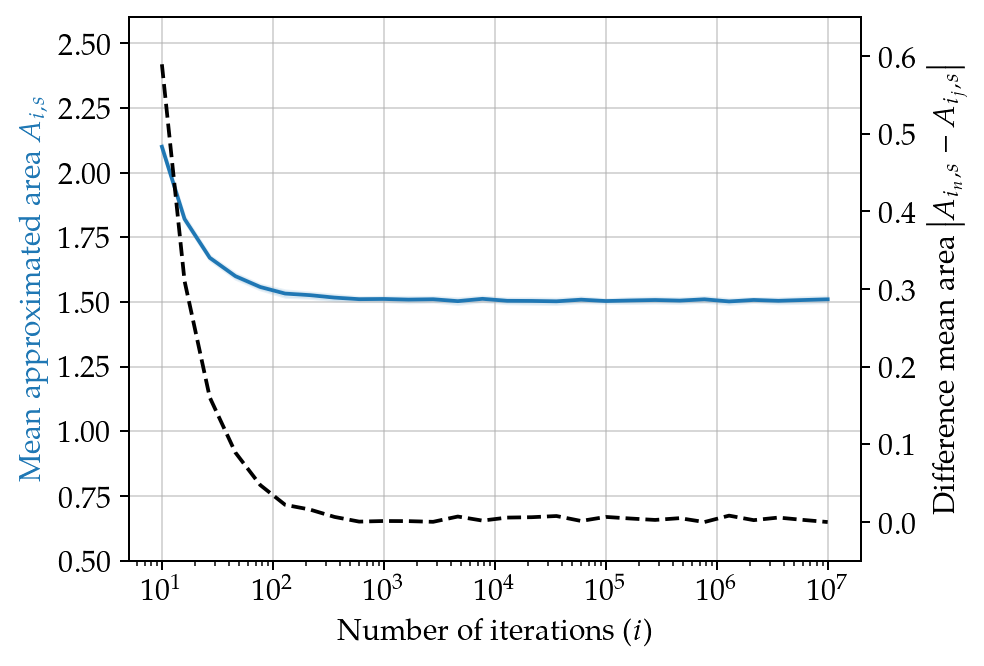

In [73]:
Plotter_I(Approx_areas_list_I_LHS, iteration_range_I_LHS)

### Comparison sampling techniques (n runs changing)

In [74]:
%%time
#shelf = shelve.open("Final_arrays_simulations/R_iter")
#Dic_PRS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = uniform_sampler)
#Dic_LHS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = latin_square_sampler)
#Dic_OS, runs_size_range = N_iter(int(1e5), int(1e4), sampling_method = orthogonal_sampler)
#shelf["Dic_PRS"] = Dic_PRS
#shelf["Dic_LHS"] = Dic_LHS
#shelf["Dic_OS"] = Dic_OS
#shelf["runs_size_range"] = runs_size_range
#shelf.close()

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 22.4 µs


In [75]:
shelf = shelve.open("Final_arrays_simulations/R_iter")
Dic_PRS = shelf["Dic_PRS"]  
Dic_LHS = shelf["Dic_LHS"]  
Dic_OS = shelf["Dic_OS"]
shelf.close()

In [76]:
#Check for repetition
print(Dic_PRS)

{10: [1.5070272, 1.502256, 1.5092448000000003, 1.5142848000000002, 1.50696, 1.5097152, 1.5081024000000003, 1.5032640000000002, 1.5097152, 1.5182496], 120: [1.5070272, 1.502256, 1.5092448000000003, 1.50696, 1.5142848000000002, 1.5081024000000003, 1.5097152, 1.5032640000000002, 1.5097152, 1.5182496, 1.4978208000000002, 1.5083712, 1.4934528, 1.5134784000000001, 1.5154944000000001, 1.5142176, 1.5234240000000003, 1.4860608000000002, 1.5136800000000001, 1.5081696, 1.4987616000000001, 1.5045408000000002, 1.5061536000000002, 1.5144864, 1.5084384000000002, 1.5147552000000002, 1.517376, 1.4932512, 1.5089088000000002, 1.5057504000000002, 1.5166368000000001, 1.5021216000000002, 1.4976192000000002, 1.5068928000000001, 1.5036672, 1.5068256000000002, 1.5130080000000001, 1.5031296, 1.5050112, 1.504272, 1.5017856000000003, 1.4984256000000002, 1.496208, 1.5019200000000001, 1.5105216000000001, 1.5099168, 1.5206688000000002, 1.4996352000000002, 1.5004416000000003, 1.5083712, 1.5060192000000001, 1.5026592,

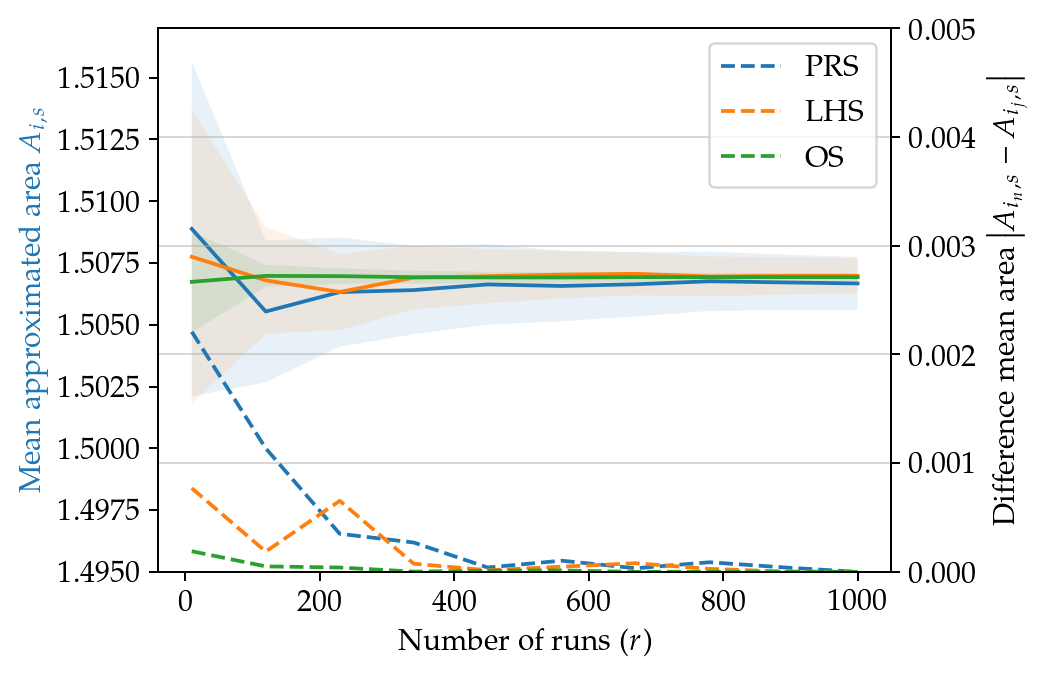

In [77]:
Plotter_N(Dic_PRS, Dic_LHS, Dic_OS)

### Statistical Tests and plots

In [78]:
%%time
#Chosen samples
#Estimator after convergence (10^5 samples, 10^4 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e5), n_runs = 100, I_min_exp = 4, I_max_exp = 4, steps = 1)
#Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e5), n_runs = 100, I_min_exp = 4, I_max_exp = 4, sampling_method= latin_square_sampler, steps = 1)
#Approx_areas_list_I_OS, iteration_range_I_OS = I_iter(sample_size = int(1e5), n_runs = 100, I_min_exp = 4, I_max_exp = 4, sampling_method= orthogonal_sampler, steps = 1)
#shelf["Approx_area_S_10^5_I_10^4_LHS"] = Approx_areas_list_I_LHS
#shelf["Approx_area_S_10^5_I_10^4_Uni"] = Approx_areas_list_I_Uni
#shelf["Approx_area_S_10^5_I_10^4_OS"] = Approx_areas_list_I_OS
#shelf.close()

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.9 µs


In [79]:
%%time
#Chosen samples
#Bad (10^1 samples, 10^1 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e1), n_runs = 100, I_min_exp = 1, I_max_exp = 1, steps = 1)
#Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e1), n_runs = 100, I_min_exp = 1, I_max_exp = 1, sampling_method= latin_square_sampler, steps = 1)
#Approx_areas_list_I_OS, iteration_range_I_OS = I_iter(sample_size = int(1e1), n_runs = 100, I_min_exp = 1, I_max_exp = 1, sampling_method= orthogonal_sampler, steps = 1)
#shelf["Approx_area_S_10^1_I_10^1_LHS"] = Approx_areas_list_I_LHS
#shelf["Approx_area_S_10^1_I_10^1_Uni"] = Approx_areas_list_I_Uni
#shelf["Approx_area_S_10^1_I_10^1_OS"] = Approx_areas_list_I_OS
#shelf.close()

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11.2 µs


In [80]:
%%time
#Chosen samples
#Bad (10^1 samples, 10^1 iteration)
#shelf = shelve.open("Final_arrays_simulations/Final_samples")
#Approx_areas_list_I_Uni, iteration_range_I_Uni = I_iter(sample_size = int(1e2), n_runs = 100, I_min_exp = 2, I_max_exp = 2, steps = 1)
#Approx_areas_list_I_LHS, iteration_range_I_LHS = I_iter(sample_size = int(1e2), n_runs = 100, I_min_exp = 2, I_max_exp = 2, sampling_method= latin_square_sampler, steps = 1)
#Approx_areas_list_I_OS, iteration_range_I_OS = I_iter(sample_size = int(1e2), n_runs = 100, I_min_exp = 2, I_max_exp = 2, sampling_method= orthogonal_sampler, steps = 1)
#shelf["Approx_area_S_10^2_I_10^2_LHS"] = Approx_areas_list_I_LHS
#shelf["Approx_area_S_10^2_I_10^2_Uni"] = Approx_areas_list_I_Uni
#shelf["Approx_area_S_10^2_I_10^2_OS"] = Approx_areas_list_I_OS
#shelf.close()

CPU times: user 17 µs, sys: 0 ns, total: 17 µs
Wall time: 32.7 µs


##### Average estimator

In [81]:
#Open objects to work with
shelf = shelve.open("Final_arrays_simulations/Final_samples")
Approx_areas_list_LHS_Av_est = shelf["Approx_area_S_10^5_I_10^4_LHS"] 
Approx_areas_list_Uni_Av_est = shelf["Approx_area_S_10^5_I_10^4_Uni"] 
Approx_areas_list_OS_Av_est = shelf["Approx_area_S_10^5_I_10^4_OS"] 

shelf.close()

#Put list in right format (meaning not a list of list)
Approx_areas_list_Uni_Av_est = sum(Approx_areas_list_Uni_Av_est, [])
Approx_areas_list_LHS_Av_est = sum(Approx_areas_list_LHS_Av_est, [])
Approx_areas_list_OS_Av_est = sum(Approx_areas_list_OS_Av_est, [])

/tmp/ipykernel_4082/2618568456.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


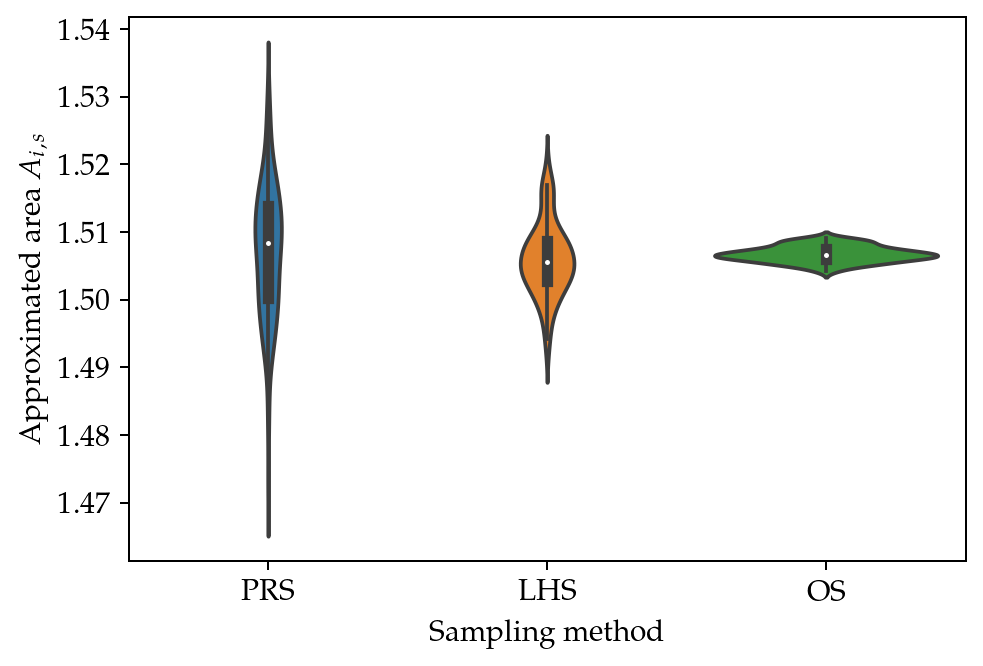

In [82]:
#Violin Plotter
fig = plt.figure()

Values_Uniform = np.array(Approx_areas_list_Uni_Av_est)
Values_LHS = np.array(Approx_areas_list_LHS_Av_est)
Values_OS = np.array(Approx_areas_list_OS_Av_est)
Data_uniform = np.array([np.repeat("PRS", len(Values_Uniform)), Values_Uniform])
Data_LHS = np.array([np.repeat("LHS", len(Values_LHS)), Values_LHS])
Data_OS = np.array([np.repeat("OS", len(Values_OS)), Values_OS])
Data = np.concatenate([Data_uniform, Data_LHS, Data_OS], axis = 1)
df = pd.DataFrame(Data.T, columns = ["Sampling methods", "Approximated Area"])
df = df.astype({"Approximated Area" : float})
ax = sns.violinplot(x="Sampling methods", y="Approximated Area", data=df)
plt.ylabel("Approximated area $A_{i,s}$")
plt.xlabel("Sampling method")

if TEX_PLOTS:
    plt.savefig('figures/violin_sampling_methods_good_estimator.pdf', bbox_inches='tight')
    
fig.show()

In [83]:
#Table 
Mean_Uni = np.mean(Approx_areas_list_Uni_Av_est) 
a_Uni = sp_confidence_interval(Approx_areas_list_Uni_Av_est)
Var_Uni = np.var(Approx_areas_list_Uni_Av_est, ddof = 1)

Mean_LHS = np.mean(Approx_areas_list_LHS_Av_est) 
a_LHS = sp_confidence_interval(Approx_areas_list_LHS_Av_est)
Var_LHS = np.var(Approx_areas_list_LHS_Av_est, ddof = 1)

Mean_OS = np.mean(Approx_areas_list_OS_Av_est) 
a_OS = sp_confidence_interval(Approx_areas_list_OS_Av_est)
Var_OS = np.var(Approx_areas_list_OS_Av_est, ddof = 1)


table = pd.DataFrame(np.array([[Mean_Uni, Mean_LHS, Mean_OS], [a_Uni, a_LHS, a_OS], [Var_Uni, Var_LHS, Var_OS]]), 
                  columns=['PRS', 'LHS', 'OS'], index = ['Mean', 'Radius', 'Variance'])

display(table)

,PRS,LHS,OS
Mean,1.507020,1.505959,1.506778
Radius,0.003924,0.002143,0.000464
Variance,0.000098,0.000029,0.000001


In [84]:
import scipy
from scipy.stats import t, f

def Welsch_test(Samples_A, Samples_B, p = 0.95):
    A_var, A_mean, A_len = np.var(Samples_A, ddof = 1), np.mean(Samples_A), len(Samples_A)
    B_var, B_mean, B_len = np.var(Samples_B, ddof = 1), np.mean(Samples_B), len(Samples_B)
    #Actual value is correct 
    Actual_value = (A_mean - B_mean)/np.sqrt((A_var/A_len) + (B_var/B_len))
    #DF is also correct
    df = ((A_var/A_len) + (B_var/B_len))**2 / (((A_var)**2 / ((A_len)**2 * (A_len - 1))) + ((B_var)**2 / ((B_len)**2 * (B_len - 1))))
    #Critical_value = t.ppf(q = ((1 - p) + 1)/2, df = df)
    Critical_value = t.ppf(q = (p + 1)/2, df = df)
    return Actual_value, Critical_value

def F_test(Samples_A, Samples_B, p = 0.95):
    A_var,  A_len = np.var(Samples_A, ddof = 1), len(Samples_A)
    B_var, B_len = np.var(Samples_B, ddof = 1), len(Samples_B)
    Actual_value = max(A_var/B_var, B_var/A_var)
    if A_var > B_var:
        n1 = A_len
        n2 = B_len
    else: 
        n2 = A_len
        n1 = B_len
    Critical_value = f.ppf(q = (1 - p), dfn = (n1 - 1), dfd = (n2 - 1))
    #Critical_value = f.ppf(q = (1 - (1-p)), dfn = (n1 - 1), dfd = (n2 - 1))
    return Actual_value, Critical_value

In [85]:

#Welch's t-test: Check if samplings methods have the same mean (Two-sided, assuming different variance)
statistic, p_value = scipy.stats.ttest_ind(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est, equal_var = False)
print("Statistics :", statistic, ", with p-value :", p_value)

Actual_value_W, Critical_value_W = Welsch_test(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est, p = 0.95)
if np.abs(Actual_value_W) < Critical_value_W:
    print("Accept: mean(X) = mean(Y)")
else: 
    print("Reject: mean(X) = mean(Y)")


#F-test Fischer: Check if Variances are different 
Actual_value_F, Critical_value_F = F_test(Approx_areas_list_Uni_Av_est, Approx_areas_list_LHS_Av_est, p = 0.95)
if Actual_value_F < Critical_value_F:
    print("Accept: Var(X) = Var(Y)")
else: 
    print("Reject: Var(X) = Var(Y)")
    
    
print(Actual_value_W, Critical_value_W)
print(Actual_value_F, Critical_value_F)

Statistics : 0.9411556887919251 , with p-value : 0.3481065183782752
Accept: mean(X) = mean(Y)
Reject: Var(X) = Var(Y)
0.9411556887919251 1.975567383286549
3.3533718355061857 0.7173285927924351


##### bad estimator

In [86]:
#Open objects to work with
shelf = shelve.open("Final_arrays_simulations/Final_samples")
Approx_areas_list_LHS_Bad_est = shelf["Approx_area_S_10^2_I_10^2_LHS"] 
Approx_areas_list_Uni_Bad_est = shelf["Approx_area_S_10^2_I_10^2_Uni"] 
Approx_areas_list_OS_Bad_est = shelf["Approx_area_S_10^2_I_10^2_OS"] 
shelf.close()

#Put list in right format (meaning not a list of list)
Approx_areas_list_Uni_Bad_est = sum(Approx_areas_list_Uni_Bad_est, [])
Approx_areas_list_LHS_Bad_est = sum(Approx_areas_list_LHS_Bad_est, [])
Approx_areas_list_OS_Bad_est = sum(Approx_areas_list_OS_Bad_est, [])




/tmp/ipykernel_4082/556087377.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


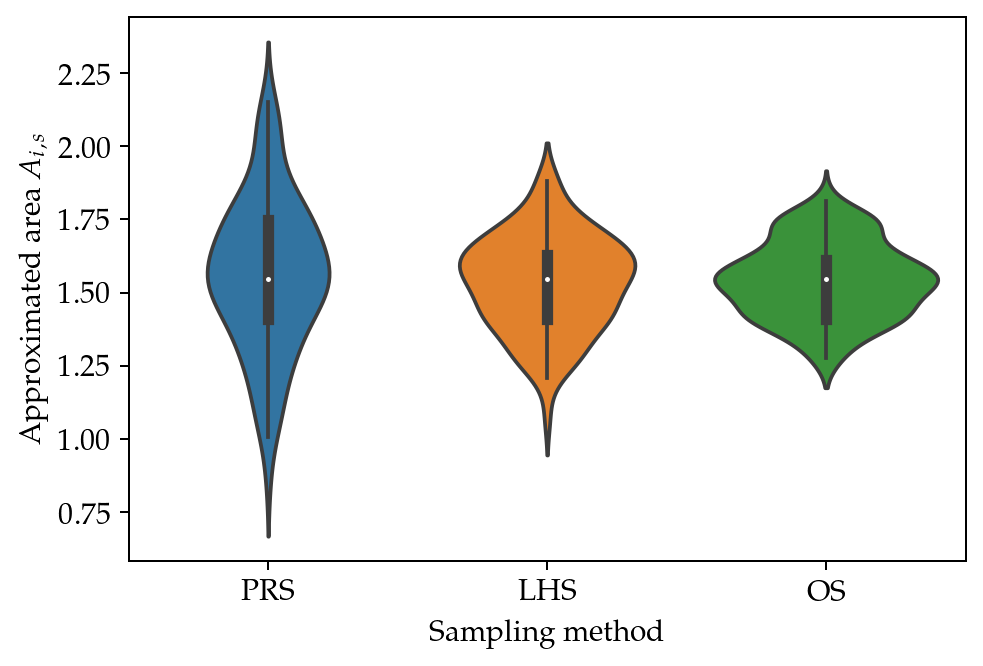

In [87]:
#Violin Plotter
fig = plt.figure()

Values_Uniform = np.array(Approx_areas_list_Uni_Bad_est)
Values_LHS = np.array(Approx_areas_list_LHS_Bad_est)
Values_OS = np.array(Approx_areas_list_OS_Bad_est)
Data_uniform = np.array([np.repeat("PRS", len(Values_Uniform)), Values_Uniform])
Data_LHS = np.array([np.repeat("LHS", len(Values_LHS)), Values_LHS])
Data_OS = np.array([np.repeat("OS", len(Values_OS)), Values_OS])
Data = np.concatenate([Data_uniform, Data_LHS, Data_OS], axis = 1)
df = pd.DataFrame(Data.T, columns = ["Sampling methods", "Approximated Area"])
df = df.astype({"Approximated Area" : float})
ax = sns.violinplot(x="Sampling methods", y="Approximated Area", data=df)
plt.ylabel("Approximated area $A_{i,s}$")
plt.xlabel("Sampling method")

#if TEX_PLOTS:
#    plt.savefig('figures/violin_sampling_methods_bad_estimator.pdf', bbox_inches='tight')
    
fig.show()

In [88]:
print(TEX_PLOTS)

True


In [89]:
#Table 
Mean_Uni = np.mean(Approx_areas_list_Uni_Bad_est) 
a_Uni = sp_confidence_interval(Approx_areas_list_Uni_Bad_est)
Var_Uni = np.var(Approx_areas_list_Uni_Bad_est, ddof = 1)

Mean_LHS = np.mean(Approx_areas_list_LHS_Bad_est) 
a_LHS = sp_confidence_interval(Approx_areas_list_LHS_Bad_est)
Var_LHS = np.var(Approx_areas_list_LHS_Bad_est, ddof = 1)

Mean_OS = np.mean(Approx_areas_list_OS_Bad_est) 
a_OS = sp_confidence_interval(Approx_areas_list_OS_Bad_est)
Var_OS = np.var(Approx_areas_list_OS_Bad_est, ddof = 1)


table = pd.DataFrame(np.array([[Mean_Uni, Mean_LHS, Mean_OS], [a_Uni, a_LHS, a_OS], [Var_Uni, Var_LHS, Var_OS]]), 
                  columns=['PRS', 'LHS', 'OS'], index = ['Mean', 'Radius', 'Variance'])

display(table)

,PRS,LHS,OS
Mean,1.560384,1.533504,1.541568
Radius,0.102662,0.064813,0.050828
Variance,0.066924,0.026674,0.016405


In [90]:

#Welch's t-test: Check if samplings methods have the same mean (Two-sided, assuming different variance)
statistic, p_value = scipy.stats.ttest_ind(Approx_areas_list_Uni_Bad_est, Approx_areas_list_LHS_Bad_est, equal_var = False)
print("Statistics :", statistic, ", with p-value :", p_value)

Actual_value_W, Critical_value_W = Welsch_test(Approx_areas_list_Uni_Bad_est, Approx_areas_list_LHS_Bad_est, p = 0.95)
if np.abs(Actual_value_W) < Critical_value_W:
    print("Accept: mean(X) = mean(Y)")
else: 
    print("Reject: mean(X) = mean(Y)")


#F-test Fischer: Check if Variances are different 
Actual_value_F, Critical_value_F = F_test(Approx_areas_list_Uni_Bad_est, Approx_areas_list_LHS_Bad_est, p = 0.95)
if Actual_value_F < Critical_value_F:
    print("Accept: Var(X) = Var(Y)")
else: 
    print("Reject: Var(X) = Var(Y)")
    
    
print(Actual_value_W, Critical_value_W)
print(Actual_value_F, Critical_value_F)

Statistics : 0.8786124973301502 , with p-value : 0.3808730679033524
Accept: mean(X) = mean(Y)
Reject: Var(X) = Var(Y)
0.8786124973301502 1.9742624794301782
2.5089951433066555 0.7173285927924351
